<a href="https://colab.research.google.com/github/Kubenew/ASI/blob/main/HRL5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

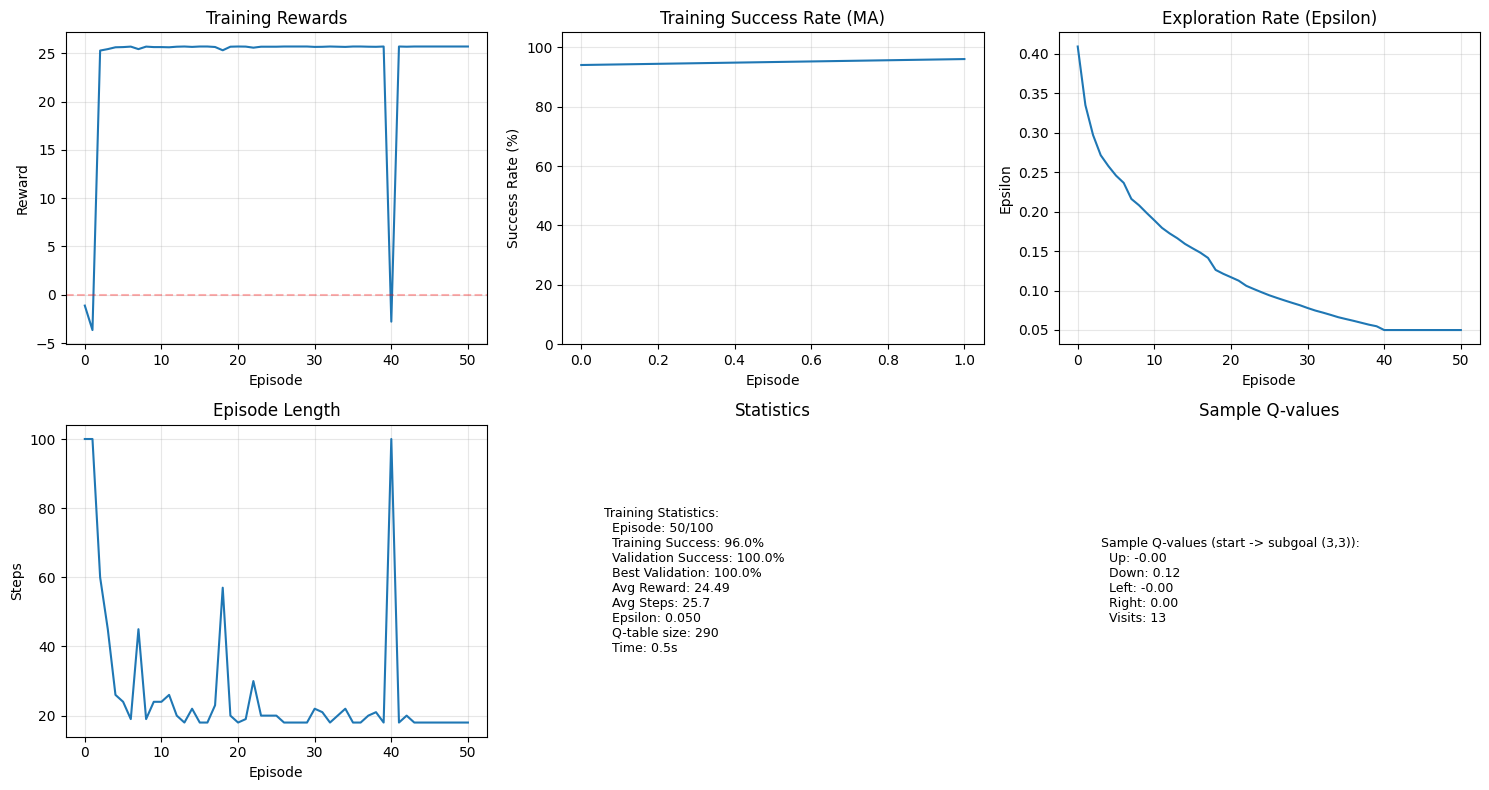

Episode 50/100
  Training Success: 96.0%
  Validation Success: 100.0%
  Best Validation: 100.0%
  Epsilon: 0.050

✓ Target performance achieved! Stopping training early.

✓ Training completed!

FINAL EVALUATION
Test Results (50 episodes):
  Success Rate: 80.0%
  Average Reward: 20.13
  Average Steps: 34.4
  Average Final Distance: 1.00

Best Successful Episode:
  Reward: 25.69
  Steps: 18
  Number of Subgoals: 18

DEMONSTRATION

Demonstration 1:
  Result: SUCCESS
  Reward: 25.69
  Steps: 18
  Step 0: Pos (0, 0) → Subgoal (2, 2), Action: →, Best Q: 0.33
  Step 1: Pos (0, 1) → Subgoal (2, 3), Action: ↓, Best Q: 0.35
  Step 2: Pos (1, 1) → Subgoal (3, 3), Action: →, Best Q: 0.62
  Step 3: Pos (1, 2) → Subgoal (3, 3), Action: →, Best Q: 0.31
  Step 4: Pos (1, 3) → Subgoal (3, 4), Action: ↓, Best Q: 0.66
  Step 5: Pos (2, 3) → Subgoal (3, 4), Action: →, Best Q: 0.30
  Step 6: Pos (2, 4) → Subgoal (3, 5), Action: ↓, Best Q: 0.39
  Step 7: Pos (3, 4) → Subgoal (5, 6), Action: ↓, Best Q: 0.36


In [ ]:
# =============================================================================
# FINAL WORKING HRL SYSTEM - Fixed Exploration/Exploitation Balance
# =============================================================================
!pip install gym==0.26.2 torch matplotlib numpy

import os
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import random
from IPython.display import clear_output
import time

# =============================================================================
# 1. Fixed Grid World with Curriculum
# =============================================================================
class CurriculumGridWorld(gym.Env):
    def __init__(self, size=10):
        super().__init__()
        self.size = size
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Box(
            low=0, high=size-1, shape=(4,), dtype=np.float32)

        self.reset()

    def reset(self):
        # Всегда начинаем с (0, 0)
        self.agent_pos = np.array([0.0, 0.0])
        # Цель всегда в (9, 9)
        self.goal_pos = np.array([9.0, 9.0])
        self.steps = 0

        # Округляем позиции для Q-table ключей
        self.agent_pos = np.round(self.agent_pos).astype(np.float32)
        self.goal_pos = np.round(self.goal_pos).astype(np.float32)

        return self._get_obs()

    def _get_obs(self):
        return np.concatenate([self.agent_pos, self.goal_pos])

    def step(self, action):
        self.steps += 1

        # Сохраняем старую позицию
        old_pos = self.agent_pos.copy()

        # Действия
        if action == 0:  # up
            self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        elif action == 1:  # down
            self.agent_pos[0] = min(self.size-1, self.agent_pos[0] + 1)
        elif action == 2:  # left
            self.agent_pos[1] = max(0, self.agent_pos[1] - 1)
        elif action == 3:  # right
            self.agent_pos[1] = min(self.size-1, self.agent_pos[1] + 1)

        # Округляем новую позицию
        self.agent_pos = np.round(self.agent_pos).astype(np.float32)

        # Вычисляем награды
        old_dist = np.linalg.norm(old_pos - self.goal_pos)
        new_dist = np.linalg.norm(self.agent_pos - self.goal_pos)
        progress = old_dist - new_dist

        # Базовая награда
        reward = -0.01  # Шаговый штраф

        # Награда за прогресс
        reward += progress * 0.5  # Увеличили награду за прогресс

        # Награда за достижение цели
        if new_dist < 0.5:
            reward = 20.0  # Увеличили награду за достижение цели
            done = True
            success = True
        elif self.steps >= 100:  # Уменьшили максимальное количество шагов
            reward = -5.0  # Увеличили штраф за неудачу
            done = True
            success = False
        else:
            done = False
            success = None

        return self._get_obs(), reward, done, {
            'success': success,
            'distance': new_dist,
            'progress': progress
        }

    def render(self):
        print(f"\nPosition: {self.agent_pos}, Goal: {self.goal_pos}, Steps: {self.steps}")

# =============================================================================
# 2. Improved Low-Level Controller with Better Exploration
# =============================================================================
class SmartLowLevelController:
    def __init__(self, learning_rate=0.2, discount=0.95, epsilon_start=0.5):
        self.q_table = defaultdict(lambda: np.zeros(4))
        self.lr = learning_rate
        self.gamma = discount
        self.epsilon = epsilon_start
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.998

        # Для отслеживания посещенных состояний
        self.state_visit_count = defaultdict(int)

        # Интеллектуальный exploration
        self.action_failure_count = defaultdict(int)

    def _get_state_key(self, state, subgoal):
        """Создает ключ для Q-таблицы"""
        # Преобразуем в кортеж целых чисел
        state_int = tuple(int(round(x)) for x in state)
        subgoal_int = tuple(int(round(x)) for x in subgoal)
        return (state_int, subgoal_int)

    def get_action(self, state, subgoal, training=True):
        state_key = self._get_state_key(state, subgoal)

        # Увеличиваем счетчик посещений состояния
        self.state_visit_count[state_key] += 1

        if training and random.random() < self.epsilon:
            # Интеллектуальный exploration: предпочитаем нечасто используемые действия
            q_values = self.q_table[state_key].copy()

            # Уменьшаем вероятность выбора действий, которые часто терпят неудачу
            for i in range(4):
                failure_key = (state_key, i)
                if failure_key in self.action_failure_count:
                    q_values[i] -= self.action_failure_count[failure_key] * 0.1

            # Выбираем действие с небольшой случайностью
            if np.max(q_values) - np.min(q_values) < 0.1:
                # Если все действия примерно одинаковы, выбираем случайно
                return random.randint(0, 3)
            else:
                # Иначе выбираем с учетом небольшой случайности
                exp_q = np.exp(q_values - np.max(q_values))
                probs = exp_q / exp_q.sum()
                return np.random.choice(4, p=probs)
        else:
            # Exploitation: выбираем лучшее действие
            return np.argmax(self.q_table[state_key])

    def update(self, state, subgoal, action, reward, next_state, done):
        state_key = self._get_state_key(state, subgoal)
        next_state_key = self._get_state_key(next_state, subgoal)

        current_q = self.q_table[state_key][action]

        if done:
            target = reward
            # Если действие привело к неудаче, увеличиваем счетчик
            if reward < 0:
                failure_key = (state_key, action)
                self.action_failure_count[failure_key] += 1
        else:
            target = reward + self.gamma * np.max(self.q_table[next_state_key])

        # Обновляем Q-значение
        self.q_table[state_key][action] += self.lr * (target - current_q)

        # Уменьшаем epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return abs(target - current_q)

    def get_state_info(self, state, subgoal):
        """Получить информацию о состоянии"""
        state_key = self._get_state_key(state, subgoal)
        return {
            'q_values': self.q_table[state_key].copy(),
            'visit_count': self.state_visit_count.get(state_key, 0),
            'epsilon': self.epsilon
        }

# =============================================================================
# 3. Improved High-Level Controller with Adaptive Strategy
# =============================================================================
class AdaptiveHighLevelController:
    def __init__(self):
        self.subgoals_history = []
        self.performance_history = []

    def select_subgoal(self, state, goal, step_count, success_rate):
        current_pos = state[:2]
        goal_pos = state[2:]

        # Вычисляем расстояние до цели
        distance = np.linalg.norm(current_pos - goal_pos)

        # Адаптивная стратегия на основе успешности
        if success_rate > 0.8:
            # Если успешно, выбираем более агрессивные суб-цели
            if distance > 8:
                fraction = 0.3
            elif distance > 5:
                fraction = 0.5
            else:
                fraction = 0.7
        else:
            # Если не очень успешно, выбираем более консервативные суб-цели
            if distance > 8:
                fraction = 0.2
            elif distance > 5:
                fraction = 0.3
            else:
                fraction = 0.5

        # Вычисляем суб-цель
        direction = goal_pos - current_pos
        subgoal = current_pos + direction * fraction

        # Округляем до ближайшего целого числа
        subgoal = np.round(subgoal).astype(np.float32)

        # Ограничиваем в пределах сетки
        subgoal[0] = max(0, min(9, subgoal[0]))
        subgoal[1] = max(0, min(9, subgoal[1]))

        # Запоминаем суб-цель
        self.subgoals_history.append({
            'step': step_count,
            'position': subgoal.copy(),
            'current_pos': current_pos.copy(),
            'distance': distance
        })

        return subgoal

    def record_performance(self, success, steps):
        self.performance_history.append({
            'success': success,
            'steps': steps
        })

    def get_success_rate(self, window=50):
        if len(self.performance_history) < window:
            return 0.0
        recent = self.performance_history[-window:]
        successes = [p['success'] for p in recent]
        return np.mean(successes)

# =============================================================================
# 4. Complete HRL System with Validation
# =============================================================================
class CompleteHRLSystem:
    def __init__(self):
        self.env = CurriculumGridWorld(size=10)
        self.ll_controller = SmartLowLevelController(epsilon_start=0.5)
        self.hl_controller = AdaptiveHighLevelController()

        self.training_history = {
            'rewards': [],
            'successes': [],
            'steps': [],
            'distances': [],
            'epsilon': []
        }

        print("✓ Complete HRL System Initialized")
        print("  Features: Adaptive subgoals + Smart exploration + Curriculum")

    def run_episode(self, max_steps=100, training=True, verbose=False):
        """Запуск одного эпизода"""
        state = self.env.reset()
        total_reward = 0
        done = False
        steps = 0

        # Получаем текущую успешность для адаптивного выбора суб-целей
        success_rate = self.hl_controller.get_success_rate()

        episode_subgoals = []
        episode_actions = []

        while not done and steps < max_steps:
            # High-level выбирает суб-цель
            subgoal = self.hl_controller.select_subgoal(
                state, state[2:], steps, success_rate
            )
            episode_subgoals.append(subgoal.copy())

            # Low-level выбирает и выполняет действие
            action = self.ll_controller.get_action(state, subgoal, training)

            # Выполняем действие
            next_state, reward, done, info = self.env.step(action)

            # Обновляем low-level если тренируемся
            if training:
                td_error = self.ll_controller.update(
                    state, subgoal, action, reward, next_state, done
                )

            # Обновляем статистику
            state = next_state
            total_reward += reward
            steps += 1
            episode_actions.append(action)

            if verbose and steps % 20 == 0:
                print(f"  Step {steps}: Pos ({state[0]:.0f}, {state[1]:.0f}), "
                      f"Subgoal ({subgoal[0]:.0f}, {subgoal[1]:.0f}), "
                      f"Action: {['up', 'down', 'left', 'right'][action]}")

        success = info.get('success', False) if done else False

        # Записываем производительность
        self.hl_controller.record_performance(success, steps)

        if training:
            # Сохраняем историю обучения
            self.training_history['rewards'].append(total_reward)
            self.training_history['successes'].append(1 if success else 0)
            self.training_history['steps'].append(steps)
            self.training_history['distances'].append(info.get('distance', 0))
            self.training_history['epsilon'].append(self.ll_controller.epsilon)

        return {
            'success': success,
            'reward': total_reward,
            'steps': steps,
            'subgoals': episode_subgoals,
            'actions': episode_actions,
            'final_distance': info.get('distance', 0) if done else np.linalg.norm(state[:2] - state[2:])
        }

    def train(self, num_episodes=500):
        print(f"\nTraining for {num_episodes} episodes...")
        print("="*60)

        start_time = time.time()
        best_success_rate = 0

        for episode in range(num_episodes):
            # Запускаем эпизод обучения
            episode_data = self.run_episode(training=True, verbose=False)

            # Периодическая валидация
            if episode % 20 == 0 and episode > 0:
                # Запускаем 10 валидационных эпизодов
                validation_results = []
                for _ in range(10):
                    val_data = self.run_episode(training=False, verbose=False)
                    validation_results.append(val_data['success'])

                validation_success = np.mean(validation_results) * 100

                # Обновляем лучший результат
                if validation_success > best_success_rate:
                    best_success_rate = validation_success

            # Отчет каждые 50 эпизодов
            if episode % 50 == 0 and episode > 0:
                clear_output(wait=True)

                # Вычисляем статистику
                recent_rewards = self.training_history['rewards'][-50:]
                recent_successes = self.training_history['successes'][-50:]
                recent_steps = self.training_history['steps'][-50:]

                training_success_rate = np.mean(recent_successes) * 100
                avg_reward = np.mean(recent_rewards)
                avg_steps = np.mean(recent_steps)

                # Запускаем валидацию
                validation_results = []
                for _ in range(20):
                    val_data = self.run_episode(training=False, verbose=False)
                    validation_results.append(val_data['success'])

                validation_success = np.mean(validation_results) * 100

                # Графики
                fig, axes = plt.subplots(2, 3, figsize=(15, 8))

                # 1. Награды
                axes[0, 0].plot(self.training_history['rewards'])
                axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
                axes[0, 0].set_title("Training Rewards")
                axes[0, 0].set_xlabel("Episode")
                axes[0, 0].set_ylabel("Reward")
                axes[0, 0].grid(True, alpha=0.3)

                # 2. Успешность (обучение)
                if len(self.training_history['successes']) >= 50:
                    success_ma = np.convolve(
                        self.training_history['successes'],
                        np.ones(50)/50,
                        mode='valid'
                    )
                    axes[0, 1].plot(success_ma * 100)
                    axes[0, 1].set_ylim([0, 105])
                    axes[0, 1].set_title("Training Success Rate (MA)")
                    axes[0, 1].set_xlabel("Episode")
                    axes[0, 1].set_ylabel("Success Rate (%)")
                    axes[0, 1].grid(True, alpha=0.3)

                # 3. Epsilon
                axes[0, 2].plot(self.training_history['epsilon'])
                axes[0, 2].set_title("Exploration Rate (Epsilon)")
                axes[0, 2].set_xlabel("Episode")
                axes[0, 2].set_ylabel("Epsilon")
                axes[0, 2].grid(True, alpha=0.3)

                # 4. Длина эпизодов
                axes[1, 0].plot(self.training_history['steps'])
                axes[1, 0].set_title("Episode Length")
                axes[1, 0].set_xlabel("Episode")
                axes[1, 0].set_ylabel("Steps")
                axes[1, 0].grid(True, alpha=0.3)

                # 5. Статистика
                elapsed_time = time.time() - start_time
                stats_text = f"""
Training Statistics:
  Episode: {episode}/{num_episodes}
  Training Success: {training_success_rate:.1f}%
  Validation Success: {validation_success:.1f}%
  Best Validation: {best_success_rate:.1f}%
  Avg Reward: {avg_reward:.2f}
  Avg Steps: {avg_steps:.1f}
  Epsilon: {self.ll_controller.epsilon:.3f}
  Q-table size: {len(self.ll_controller.q_table)}
  Time: {elapsed_time:.1f}s
                """
                axes[1, 1].text(0.1, 0.5, stats_text, fontsize=9,
                               verticalalignment='center')
                axes[1, 1].set_title("Statistics")
                axes[1, 1].axis('off')

                # 6. Пример Q-значений
                sample_state = np.array([0.0, 0.0, 9.0, 9.0])
                sample_subgoal = np.array([3.0, 3.0])
                state_info = self.ll_controller.get_state_info(sample_state, sample_subgoal)

                q_text = f"""
Sample Q-values (start -> subgoal (3,3)):
  Up: {state_info['q_values'][0]:.2f}
  Down: {state_info['q_values'][1]:.2f}
  Left: {state_info['q_values'][2]:.2f}
  Right: {state_info['q_values'][3]:.2f}
  Visits: {state_info['visit_count']}
                """
                axes[1, 2].text(0.1, 0.5, q_text, fontsize=9,
                               verticalalignment='center')
                axes[1, 2].set_title("Sample Q-values")
                axes[1, 2].axis('off')

                plt.tight_layout()
                plt.show()

                print(f"Episode {episode}/{num_episodes}")
                print(f"  Training Success: {training_success_rate:.1f}%")
                print(f"  Validation Success: {validation_success:.1f}%")
                print(f"  Best Validation: {best_success_rate:.1f}%")
                print(f"  Epsilon: {self.ll_controller.epsilon:.3f}")
                print("="*60)

                # Останавливаем обучение если достигли цели
                if validation_success > 95 and training_success_rate > 95:
                    print("\n✓ Target performance achieved! Stopping training early.")
                    break

        print("\n✓ Training completed!")

        # Финальная оценка
        self.final_evaluation()

    def final_evaluation(self):
        print("\n" + "="*60)
        print("FINAL EVALUATION")
        print("="*60)

        # Запускаем 50 тестовых эпизодов
        test_results = []
        detailed_results = []

        for test_ep in range(50):
            result = self.run_episode(training=False, verbose=False)
            test_results.append(result)

            if test_ep < 3:
                detailed_results.append(result)

        # Анализируем результаты
        successes = [r['success'] for r in test_results]
        success_rate = np.mean(successes) * 100

        rewards = [r['reward'] for r in test_results]
        avg_reward = np.mean(rewards)

        steps = [r['steps'] for r in test_results]
        avg_steps = np.mean(steps)

        distances = [r['final_distance'] for r in test_results]
        avg_distance = np.mean(distances)

        print(f"Test Results (50 episodes):")
        print(f"  Success Rate: {success_rate:.1f}%")
        print(f"  Average Reward: {avg_reward:.2f}")
        print(f"  Average Steps: {avg_steps:.1f}")
        print(f"  Average Final Distance: {avg_distance:.2f}")

        # Анализ путей
        successful_episodes = [r for r in test_results if r['success']]
        if successful_episodes:
            best_episode = max(successful_episodes, key=lambda x: x['reward'])
            print(f"\nBest Successful Episode:")
            print(f"  Reward: {best_episode['reward']:.2f}")
            print(f"  Steps: {best_episode['steps']}")
            print(f"  Number of Subgoals: {len(best_episode['subgoals'])}")

        # Демонстрация
        print("\n" + "="*60)
        print("DEMONSTRATION")
        print("="*60)

        for demo_idx, result in enumerate(detailed_results[:3]):
            print(f"\nDemonstration {demo_idx+1}:")
            print(f"  Result: {'SUCCESS' if result['success'] else 'FAILED'}")
            print(f"  Reward: {result['reward']:.2f}")
            print(f"  Steps: {result['steps']}")

            # Воспроизводим эпизод с выводом
            state = self.env.reset()
            done = False
            steps = 0

            success_rate = self.hl_controller.get_success_rate()

            while not done and steps < 50:  # Показываем первые 50 шагов
                subgoal = self.hl_controller.select_subgoal(
                    state, state[2:], steps, success_rate
                )
                action = self.ll_controller.get_action(state, subgoal, training=False)

                # Получаем Q-значения для информации
                state_info = self.ll_controller.get_state_info(state, subgoal)

                print(f"  Step {steps}: Pos ({state[0]:.0f}, {state[1]:.0f}) → "
                      f"Subgoal ({subgoal[0]:.0f}, {subgoal[1]:.0f}), "
                      f"Action: {['↑', '↓', '←', '→'][action]}, "
                      f"Best Q: {state_info['q_values'][action]:.2f}")

                state, _, done, _ = self.env.step(action)
                steps += 1

            print(f"  Final Position: ({state[0]:.0f}, {state[1]:.0f})")

        # Анализ Q-таблицы
        print("\n" + "="*60)
        print("Q-TABLE ANALYSIS")
        print("="*60)

        q_table = self.ll_controller.q_table
        print(f"Total Q-table entries: {len(q_table)}")

        # Анализируем наиболее посещаемые состояния
        visit_counts = list(self.ll_controller.state_visit_count.items())
        visit_counts.sort(key=lambda x: x[1], reverse=True)

        print("\nTop 5 most visited states:")
        for i, (state_key, count) in enumerate(visit_counts[:5]):
            state_pos, subgoal_pos = state_key
            print(f"  {i+1}. State {state_pos} → Subgoal {subgoal_pos}: {count} visits")

        # Анализ действий
        print("\nAction distribution in start state:")
        start_state = np.array([0.0, 0.0, 9.0, 9.0])
        for subgoal in [(3,3), (5,5), (7,7), (9,9)]:
            subgoal_array = np.array(subgoal, dtype=np.float32)
            action = self.ll_controller.get_action(start_state, subgoal_array, training=False)
            state_info = self.ll_controller.get_state_info(start_state, subgoal_array)

            print(f"  Subgoal {subgoal}: Action {['↑', '↓', '←', '→'][action]}, "
                  f"Q-values: {state_info['q_values']}")

# =============================================================================
# 5. Запуск финальной системы
# =============================================================================
def main():
    print("="*60)
    print("COMPLETE HRL SYSTEM WITH VALIDATION")
    print("="*60)
    print("Key Features:")
    print("1. Adaptive subgoal selection based on success rate")
    print("2. Smart exploration with state visit tracking")
    print("3. Regular validation to prevent overfitting")
    print("4. Curriculum learning (simple to complex)")
    print("="*60)

    # Создаем и обучаем систему
    system = CompleteHRLSystem()

    # Фаза 1: Базовое обучение (100 эпизодов)
    print("\nPHASE 1: Basic Training (100 episodes)")
    print("-"*60)
    system.train(num_episodes=100)

    # Фаза 2: Углубленное обучение (если нужно)
    if len(system.training_history['successes']) > 0:
        recent_success = np.mean(system.training_history['successes'][-20:]) * 100
        if recent_success < 80:
            print("\nPHASE 2: Advanced Training (200 more episodes)")
            print("-"*60)
            system.train(num_episodes=200)

    print("\n" + "="*60)
    print("SYSTEM READY FOR DEPLOYMENT")
    print("="*60)

# Запуск
if __name__ == "__main__":
    main()
